In [7]:
import numpy as np
import ctypes
import os

readPTU = ctypes.WinDLL (r"S:\64bit dll 's\PQ_PTU_sf\release\PQ_PTU.dll")
_SplitOnTacs = ctypes.CDLL('ProcessPhotonStream.dll').SplitOnTacs

def ptuHeader_wrap (fname):
    """wrapper for PQ_ptuHeader_sf function. 
    Returns number of entries and writes  the header in a subdirectory named header."""
    fpin = ctypes.create_string_buffer(fname)
    #strip file name for header location
    root, file = os.path.split(fname)
    name, _ = os.path.splitext(file)
    try:
        os.mkdir("header")
    except:
        print("header dir already exists")
    outfile =  os.path.join(b"header", name + b".txt")
    fpout = ctypes.create_string_buffer(outfile)
    return readPTU.PQ_ptuHeader_sf(fpin,fpout)

def ptu_wrap(fname, NumRecords):
    #initialize variables in memory for the c routine to write in
    c_longlong_p = ctypes.POINTER(ctypes.c_longlong) #init class for long long pointer
    c_ubyte_p = ctypes.POINTER(ctypes.c_ubyte) #init class for unsigned char pointer
    c_int_p = ctypes.POINTER(ctypes.c_int) #init class for int pointer


    length = ctypes.c_longlong(NumRecords)
    fpin = ctypes.create_string_buffer(fname)

    eventN = np.zeros(NumRecords).astype(np.int64)
    eventN_p = eventN.ctypes.data_as(c_longlong_p)

    tac = np.zeros(NumRecords).astype(np.int32)
    tac_p = tac.ctypes.data_as(c_int_p)

    t = np.zeros(NumRecords).astype(np.int64)
    t_p = t.ctypes.data_as(c_longlong_p)

    can = np.zeros(NumRecords).astype(np.uint8)
    can_p = can.ctypes.data_as(c_ubyte_p)

    j = ctypes.c_longlong()
    ov_in = ctypes.c_longlong()
    stage = ctypes.c_int()

    readPTU.PQ_ptu_sf(fpin, length, eventN_p, tac_p, t_p, can_p, ctypes.byref(j), ctypes.byref(ov_in), ctypes.byref(stage))
    
    return eventN, tac, t, can

import logging
logger = logging.getLogger('readptu')
def read_header(header_name):
    header = np.genfromtxt(r"header\\Crimson20nm_Exc_640_1perc_STED100perc_0016AU.txt", delimiter = '\n', dtype = str)
    for el in header:
        if "ImgHdr_PixX" in el:
            dimX = int(el[40:])
        if "ImgHdr_PixY" in el:
            dimY = int(el[40:])
        if "ImgHdr_TimePerPixel" in el:
            dwelltime = float(el[40:]) * 1e-3
        if "MeasDesc_GlobalResolution" in el:
            counttime = float(el[40:])
    try:
        return dimX, dimY, dwelltime, counttime
    except NameError:
        logger.error("not all needed variables were found")
        raise
        
def SplitOnTacs_wrap(eventN, tac, t, can, dimX, dimY, dwelltime, counttime, NumRecords, 
                     gate = 3328, uselines = np.array([1])):
    c_longlong_p = ctypes.POINTER(ctypes.c_longlong) #init class for long long pointer
    c_ubyte_p = ctypes.POINTER(ctypes.c_ubyte) #init class for unsigned char pointer
    c_int_p = ctypes.POINTER(ctypes.c_int) #init class for int pointer
    
    eventN_p = eventN.ctypes.data_as(c_longlong_p)
    tac_p = tac.ctypes.data_as(c_int_p)
    t_p = t.ctypes.data_as(c_longlong_p)
    can_p = can.ctypes.data_as(c_ubyte_p)
    C_dimX = ctypes.c_int(dimX)
    C_dimY = ctypes.c_int(dimY)
    C_dwelltime = ctypes.c_float(dwelltime)
    C_counttime = ctypes.c_float(counttime)
    C_NumRecords = ctypes.c_int(NumRecords)
    uselines_p = uselines.ctypes.data_as(c_ubyte_p)
    C_gate = ctypes.c_int(gate)
    C_nlines = ctypes.c_int(uselines.shape[0])
    imA = np.zeros(dimX * dimY).astype(np.int)
    imB = np.zeros(dimX * dimY).astype(np.int)
    imA_p = imA.ctypes.data_as(c_int_p)
    imB_p = imB.ctypes.data_as(c_int_p)
    #initialize empty arrays and handles for imA, imB
    _SplitOnTacs(eventN_p, tac_p, t_p, can_p, C_dimX, C_dimY, C_dwelltime, C_counttime, C_NumRecords, C_gate, 
                 C_nlines, uselines_p, imA_p, imB_p)
    imA = imA.reshape((dimX, dimY))
    imB = imB.reshape((dimX, dimY))
    return imA, imB

header dir already exists


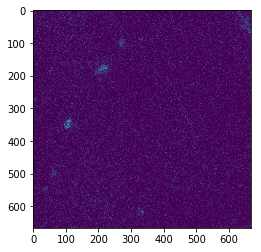

In [3]:
import ctypes
import numpy as np
import os
import matplotlib.pyplot as plt
from cpp_wrappers import *

fname = b"N:\\Singlem\\singlem19-1\\March\\06_FRC_20nmCrimson_NV\\STEDPowerSeries\\Crimson20nm_Exc_640_1perc_STED050perc_0016AU.ptu"
def CreateImagesFromPTU(fname, gate =3328, uselines = np.ones(1).astype(np.ubyte)):
    NumRecords = ptuHeader_wrap (fname)
    eventN, tac, t, can = ptu_wrap(fname, NumRecords)
    root, file = os.path.split(fname)
    name, _ = os.path.splitext(file)
    header_name = os.path.join(b"header", name + b".txt")
    dimX, dimY, dwelltime, counttime = read_header(header_name)
    imA, imB = SplitOnTacs_wrap(eventN, tac, t, can, dimX, dimY, 
                                dwelltime, counttime, NumRecords, gate, uselines = uselines)
    return imA, imB
imA, imB = CreateImagesFromPTU(fname, uselines = np.ones(10).astype(np.ubyte))
plt.imshow(imA)

## Read in PTU files using picoquant routine

In [10]:
Rimage = np.zeros((667,667))
inscan = False
line = 0
linescan = 0
Nlinescans = 10
dwelltime = 10e-6
timebin = 25e-9
for i in range(NumRecords):
    if can[i] == 65: 
        inscan = True
        startline = t[i]
    elif can[i] == 66: 
        inscan = False
        linescan += 1
        if linescan >= Nlinescans:
            line+=1
            linescan = 0
    elif (can[i] in [1,3] and inscan):
        pixel = int((t[i] - startline ) * timebin / dwelltime)
        try: 
            Rimage[line, pixel] += 1
        except IndexError:
            pass #catch exception that photon arrives at same macrotime as linestop
            
    elif (can[i] in [0,2] and inscan):
        pass #not implemented
        

1253416.0

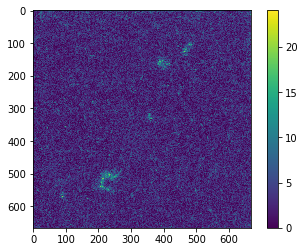

In [11]:
plt.imshow(Rimage)
plt.colorbar()
np.sum(Rimage)

In [68]:
linetimes = np.zeros(6670)
j = 0
for i in range(NumRecords):
    if can[i] ==65:
        tstart = t[i]
    if can[i] ==66:
        tstop = t[i]
        linetimes[j] = tstop - tstart
        j += 1

In [176]:
linetimes

array([266808., 266808., 266808., ..., 266804., 266808., 266808.])

In [61]:
i=0
N65=0
N66=0
N68 = 0
for el in can:
    if el == 65:
        N65 +=1
    elif el ==66:
        N66 += 1
    elif el == 68:
        N68 += 1
    elif el > 4:
        print("odd element found: " + str(el))
print("N65 is " + str(N65))
print("N66 is " + str(N66))
print("N68 is " + str(N68))
print("i is " + str(i))

N65 is 6670
N66 is 6670
N68 is 1
i is 0


In [157]:
%%file ProcessPhotonStream.cpp

#include <stdio.h>

extern "C" int SplitOnTacs(long long * eventN,
                          int * tac,
                          long long * t,
                          unsigned __int8 * can,
                          int dimX,
                          int dimY,
                          float dwelltime,
                          float counttime,
                          int NumRecords,
                          int gate,
                          int nlines,
                          char * uselines,
                          int * imA,
                          int * imB){
    int i, startline, pixel;
    int j = 0, line = 0;
    int inscanpxl = 0, unaccounted = 0, linemarkers = 0, outscan = 0, GChannel = 0;
    int badcalculatedpxl=0, gatedpxl =0;
    bool inscan(false);
    float macrotime2pixel = counttime / dwelltime;
    int timedif;
    //printf("macrotime2pixel is %d \n", (int)(macrotime2pixel*timedif));
    
    for(i = 0; i < NumRecords; i++){
        if(can[i] == 65){
            inscan = true;
            startline = t[i];
            linemarkers++;
        } else if( can[i] == 66){
            inscan = false;
            j++;
            linemarkers ++;
            if (j >= nlines) {
                line ++;
                j = 0;
            }
        } else if ((can[i] == 1 or can[i] == 3) and inscan and uselines[j] and tac[i] > gate) {
            //image is stored as 1D array
            //macrotime2pixel is calculated once for computational efficiency
            
            timedif = t[i] - startline; //cast long long to int
            pixel = timedif * macrotime2pixel; 
            if (pixel < dimX){
                if (tac[i] % 2 == 0) imA[line * dimX + pixel]++;
                else if (tac[i] % 2 == 1) imB[line * dimX + pixel]++;
                inscanpxl ++;
            } else badcalculatedpxl++;
        } else if ((can[i] == 0 or can[i] == 2)) GChannel++;
        else if (not inscan) outscan++;
        else if (tac[i] < gate) gatedpxl ++;
        else unaccounted ++;
    }
    printf("inscan counts is %d \n", inscanpxl);
    printf("linemarker count is %d \n", linemarkers);
    printf("pixels recorded while outside of scan is %d \n", outscan);
    printf("pixels recorded in the Green channel is %d \n", GChannel);
    printf("bad calculated pixels is %d \n", badcalculatedpxl);
    printf("number of gated pixels is %d \n", gatedpxl);
    printf("unaccounted pixels is %d \n", unaccounted);
    printf("photon bookkeeping: %d photons remaining\n", NumRecords - inscanpxl - linemarkers - unaccounted - 
           outscan - GChannel - badcalculatedpxl - gatedpxl);
    return 0;
}

Overwriting ProcessPhotonStream.cpp


In [158]:
!gcc -c -o ProcessPhotonStream.o ProcessPhotonStream.cpp
!gcc -o ProcessPhotonStream.dll -shared ProcessPhotonStream.o

In [173]:
%%file ptu_wrapper.py

import numpy as np
import ctypes
import os

readPTU = ctypes.WinDLL (r"S:\64bit dll 's\PQ_PTU_sf\release\PQ_PTU.dll")
_SplitOnTacs = ctypes.CDLL('ProcessPhotonStream.dll').SplitOnTacs

def ptuHeader_wrap (fname):
    """wrapper for PQ_ptuHeader_sf function. 
    Returns number of entries and writes  the header in a subdirectory named header."""
    fpin = ctypes.create_string_buffer(fname)
    #strip file name for header location
    root, file = os.path.split(fname)
    name, _ = os.path.splitext(file)
    
    try:
        print(os.path.join(root, "header"))
        os.mkdir(os.path.join(root, "header"))
    except:
        print("header dir already exists")
    outfile =  os.path.join(root, b"header", name + b".txt")
    fpout = ctypes.create_string_buffer(outfile)
    return readPTU.PQ_ptuHeader_sf(fpin,fpout)

def ptu_wrap(fname, NumRecords):
    #initialize variables in memory for the c routine to write in
    c_longlong_p = ctypes.POINTER(ctypes.c_longlong) #init class for long long pointer
    c_ubyte_p = ctypes.POINTER(ctypes.c_ubyte) #init class for unsigned char pointer
    c_int_p = ctypes.POINTER(ctypes.c_int) #init class for int pointer


    length = ctypes.c_longlong(NumRecords)
    fpin = ctypes.create_string_buffer(fname)

    eventN = np.zeros(NumRecords).astype(np.int64)
    eventN_p = eventN.ctypes.data_as(c_longlong_p)

    tac = np.zeros(NumRecords).astype(np.int32)
    tac_p = tac.ctypes.data_as(c_int_p)

    t = np.zeros(NumRecords).astype(np.int64)
    t_p = t.ctypes.data_as(c_longlong_p)

    can = np.zeros(NumRecords).astype(np.uint8)
    can_p = can.ctypes.data_as(c_ubyte_p)

    j = ctypes.c_longlong()
    ov_in = ctypes.c_longlong()
    stage = ctypes.c_int()

    readPTU.PQ_ptu_sf(fpin, length, eventN_p, tac_p, t_p, can_p, ctypes.byref(j), ctypes.byref(ov_in), ctypes.byref(stage))
    
    return eventN, tac, t, can

import logging
logger = logging.getLogger('readptu')
def read_header(header_name):
    header = np.genfromtxt(r"header\\Crimson20nm_Exc_640_1perc_STED100perc_0016AU.txt", delimiter = '\n', dtype = str)
    for el in header:
        if "ImgHdr_PixX" in el:
            dimX = int(el[40:])
        if "ImgHdr_PixY" in el:
            dimY = int(el[40:])
        if "ImgHdr_TimePerPixel" in el:
            dwelltime = float(el[40:]) * 1e-3
        if "MeasDesc_GlobalResolution" in el:
            counttime = float(el[40:])
    try:
        return dimX, dimY, dwelltime, counttime
    except NameError:
        logger.error("not all needed variables were found")
        raise

def SplitOnTacs_wrap(eventN, tac, t, can, dimX, dimY, dwelltime, counttime, NumRecords, uselines, gate = 3328):
    c_longlong_p = ctypes.POINTER(ctypes.c_longlong) #init class for long long pointer
    c_ubyte_p = ctypes.POINTER(ctypes.c_ubyte) #init class for unsigned char pointer
    c_int_p = ctypes.POINTER(ctypes.c_int) #init class for int pointer
    
    eventN_p = eventN.ctypes.data_as(c_longlong_p)
    tac_p = tac.ctypes.data_as(c_int_p)
    t_p = t.ctypes.data_as(c_longlong_p)
    can_p = can.ctypes.data_as(c_ubyte_p)
    C_dimX = ctypes.c_int(dimX)
    C_dimY = ctypes.c_int(dimY)
    C_dwelltime = ctypes.c_float(dwelltime)
    C_counttime = ctypes.c_float(counttime)
    C_NumRecords = ctypes.c_int(NumRecords)
    uselines_p = uselines.ctypes.data_as(c_ubyte_p)
    C_gate = ctypes.c_int(gate)
    C_nlines = ctypes.c_int(uselines.shape[0])
    imA = np.zeros(dimX * dimY).astype(np.int)
    imB = np.zeros(dimX * dimY).astype(np.int)
    imA_p = imA.ctypes.data_as(c_int_p)
    imB_p = imB.ctypes.data_as(c_int_p)
    #initialize empty arrays and handles for imA, imB
    _SplitOnTacs(eventN_p, tac_p, t_p, can_p, C_dimX, C_dimY, C_dwelltime, C_counttime, C_NumRecords, C_gate, 
                 C_nlines, uselines_p, imA_p, imB_p)
    imA = imA.reshape((dimX, dimY))
    imB = imB.reshape((dimX, dimY))
    return imA, imB

Overwriting ptu_wrapper.py


In [1]:
%%file run_PhStream.py

import ctypes
import numpy as np
import os
from ptu_wrapper import *
import matplotlib.pyplot as plt
from PIL import Image


def genImABfromptu(fname, uselines = np.ones(1), gate = 3228):
    NumRecords = ptuHeader_wrap (fname)
    eventN, tac, t, can = ptu_wrap(fname, NumRecords)
    root, file = os.path.split(fname)
    name, _ = os.path.splitext(file)
    header_name = os.path.join(root, b"header", name + b".txt")
    print('number of records is ' + str(NumRecords))

    dimX, dimY, dwelltime, counttime = read_header(header_name)
    #uselines = np.ones(1).astype(np.ubyte)
    imA, imB = SplitOnTacs_wrap(eventN, tac, t, can, dimX, dimY, dwelltime, counttime, 
                                NumRecords, gate = gate, uselines = uselines)
    print("total image intensity is "  + str(np.sum(imA+imB)))

    im = Image.fromarray(imA)
    outname = str(os.path.join(wdir, file[:-4] + b'_imA.tiff'), encoding='utf-8')
    im.save(outname)
    im = Image.fromarray(imB)
    outname = str(os.path.join(wdir, file[:-4] + b'_imB.tiff'), encoding='utf-8')
    im.save(outname)
    

wdir = b'N:\\Singlem\\singlem19-1\\March\\29_20nmCrimson_NV'
file = b'2019032920nmCrimsonExc640_4-3STED775_100_1-25W.ptu'
fname = os.path.join(wdir,file)
genImABfromptu(fname, uselines = np.ones(1, dtype = np.int))
#wdir = b"N:\\Singlem\\singlem19-1\\March\\06_FRC_20nmCrimson_NV\\STEDPowerSeries\\"
#file = b"Crimson20nm_Exc_640_1perc_STED010perc_0016AU.ptu"
#fname = os.path.join(wdir,file)
#genImABfromptu(fname, uselines = np.ones(10, dtype = np.int))

Overwriting run_PhStream.py


In [2]:
!python run_PhStream.py

header dir already exists


Traceback (most recent call last):
  File "run_PhStream.py", line 35, in <module>
    genImABfromptu(fname, uselines = np.ones(1, dtype = np.int))
  File "run_PhStream.py", line 12, in genImABfromptu
    eventN, tac, t, can = ptu_wrap(fname, NumRecords)
  File "K:\vanderVoortN\FRC\dev\readPTU\ptu_wrapper.py", line 36, in ptu_wrap
    eventN = np.zeros(NumRecords).astype(np.int64)
ValueError: negative dimensions are not allowed


In [3]:
!python run_PhStream.py

header dir already exists


Traceback (most recent call last):
  File "run_PhStream.py", line 35, in <module>
    genImABfromptu(fname, uselines = np.ones(1, dtype = np.int))
  File "run_PhStream.py", line 12, in genImABfromptu
    eventN, tac, t, can = ptu_wrap(fname, NumRecords)
  File "K:\vanderVoortN\FRC\dev\readPTU\ptu_wrapper.py", line 36, in ptu_wrap
    eventN = np.zeros(NumRecords).astype(np.int64)
ValueError: negative dimensions are not allowed
